In [2]:
!pip install control

     |████████████████████████████████| 339 kB 12.6 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=36efcd063fce71bac3607382023e02b9ec51e5a21ad89e06450de97f8a032165
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


Summary statistics:
* Cost function calls: 1092
* System simulations: 1092
[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]


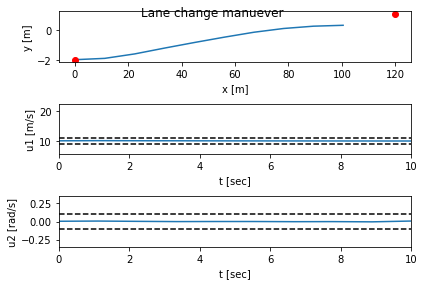

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  6 12:54:40 2021

@author: Vadim
"""

# optimal_bench.py - benchmarks for optimal control package
# RMM, 27 Feb 2020
#
# This benchmark tests the timing for the optimal control module
# (control.optimal) and is intended to be used for helping tune the
# performance of the functions used for optimization-base control.
import numpy as np
import math
import control as ct
import control.flatsys as flat
import control.optimal as opt
import matplotlib.pyplot as plt
import logging
import time
import os

#
# Vehicle steering dynamics
#
# The vehicle dynamics are given by a simple bicycle model.  We take the state
# of the system as (x, y, theta) where (x, y) is the position of the vehicle
# in the plane and theta is the angle of the vehicle with respect to
# horizontal.  The vehicle input is given by (v, phi) where v is the forward
# velocity of the vehicle and phi is the angle of the steering wheel.  The
# model includes saturation of the vehicle steering angle.
#
# System state: x, y, theta
# System input: v, phi
# System output: x, y
# System parameters: wheelbase, maxsteer
#
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    # Saturate the steering input (use min/max instead of clip for speed)
    phi = max(-phimax, min(u[1], phimax))
    # Return the derivative of the state
    return np.array([
        math.cos(x[2]) * u[0],            # xdot = cos(theta) v
        math.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * math.tan(phi)        # thdot = v/l tan(phi)
    ])


def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

# Initial and final conditions
x0 = [0., -2., 0.]; u0 = [10., 0.]
xf = [120., 1.1, 0.]; uf = [10., 0.]
Tf = 10
# Define the time horizon (and spacing) for the optimization
horizon = np.linspace(0, Tf, 10, endpoint=True)
# Provide an intial guess (will be extended to entire horizon)
bend_left = [10, 0.01]          # slight left veer

# Set up the cost functions
Q = np.diag([5, 10, 1])     # keep lateral error low
R = np.diag([.1, 1])          # minimize applied inputs
quad_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
#        
res = opt.solve_ocp(
        vehicle, horizon, x0, quad_cost,
        initial_guess=bend_left, print_summary=False,
        # solve_ivp_kwargs={'atol': 1e-2, 'rtol': 1e-2},
        minimize_method='trust-constr',
        minimize_options={'finite_diff_rel_step': 0.01},
    )
#       
u = res.inputs
t, y = ct.input_output_response(vehicle, horizon, u, x0) 
#y = res.states
#t = res.time

print(t)

# Plot the results
plt.subplot(3, 1, 1)
plt.plot(y[0], y[1])
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.subplot(3, 1, 2)
plt.plot(t, u[0])
plt.axis([0, 10, 5.5, 22.5])
plt.plot([0, 10], [9, 9], 'k--', [0, 10], [11, 11], 'k--')
plt.xlabel("t [sec]")
plt.ylabel("u1 [m/s]")

plt.subplot(3, 1, 3)
plt.plot(t, u[1])
plt.axis([0, 10, -0.35, 0.35])
plt.plot([0, 10], [-0.1, -0.1], 'k--', [0, 10], [0.1, 0.1], 'k--')
plt.xlabel("t [sec]")
plt.ylabel("u2 [rad/s]")

plt.suptitle("Lane change manuever")
plt.tight_layout()
plt.show()